# Objectives

<b>1.Generate Samples from a High Dimensional Distribution using DCGANs :</b> GANs tackle a very fundamental problem in machine learning. We can think of images as vectors in a very high dimensional space. It is reasonable to think that images of any class, say flowers, would have some inherent probability distribution. Given samples from this distribution, it is desirable to be able to estimate its density so that we can sample from it. As we saw in the beginning of this course, this is quite challenging as when working in such high dimensional spaces we never have enough samples to estimate the density. The fact that GANs can use a simple idea to sample from the distribution is quite remarkable.

<b>2. Perform Image Completion using the above model to fill in the incomplete parts of our images:</b> Since the GAN learns something fundamental about the underlying structure of a class of images we can imagine using it for many tasks. One such application is image completion. In this task we have an image with a patch missing(or we want to replace something in an image) with and we want to fill it with something realistic. We see that a GAN can be quite good at this task. This method of image completion has the advantage that we don't define any loss in terms of what was originally present in the patch. We rely on the networks ability to generate realistic images and let it fill the patch with whatever fits the context.

# Dataset

We trained our GAN on two classes of images, namely flowers and faces. The choice of dataset is very important. While we might like a network that can generate all kinds of realistic images this is a fairly complicated task. Each class will probably have its own distribution and when training, the network would need to be able to estimate many distributions and also keep track of them seperately. Otherwise it would mix them up and we can image a situation in which a network trained on pictures of birds and humans starts putting beaks on humany faces!

Even within a category we need to restrict ourselves to images taken from similar angles.  We looked at various datasets and there often tends to be lots of variation in angles the photo is taken at and kind of noise in the background. After a thorough survey we decided to start with flowers. At the suggestion of Prof. Belhumeur we also trained our network on faces. This allowed us to see results on two different categories each with its own complications. For both the data sets we seperated 90% out for trainig the GAN and used the other 10% for testing image completion.

## Flowers

<b> Dataset: 102 Category Flower Dataset, Visual Geometry Group, University of Oxford</b> <br />
Original Data Source: http://www.robots.ox.ac.uk/~vgg/data/flowers/102/ ~8,000 images from 102 categories<br />
After augmentation: https://www.dropbox.com/s/2n7qd2qq39hsmnw/jpg2.zip?dl=0


Some Samples
<img src='assets/flower_training_set.jpg'>

Flowers are a very interesting class of images. Most pictures of flowers tend to be from the same angle. However flowers exhibit a wide range of colors and structures which make their distribution quite complicated. The Oxford flower dataset is the biggest collection of flowers we could find. Since it only has 8000 images and we need much more we did some basic augmentation such as rotation and shear to make the datatset 10 times as big. Additionally we made our final images 64x64x3.

## Faces


<b>Large-scale CelebFaces Attributes (CelebA) Dataset, Multimedia Laboratory, The Chinese University of Hong Kong</b> <br />
Original Data Source: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html 202,599 images of celebrity faces


<b>LFWcrop Face Dataset</b>: <br />
Original Data Source: http://conradsanderson.id.au/lfwcrop/ 13,233 images of human faces



Some samples:
<img src='assets/faces_training_set.jpg'>

Faces is the class of images with the biggest datasets of pictures taken from the same angle. Thus it is easy to prepare a large dataset to train the network. For our project we combined the celebA and LWF cropped(LFW datatset cropped to include just the face) data sets. While compared to flowers, there is less variation in structure and color but the dataset has its own challenges. Faces are perhaps the one class that humans can reconize the best. As opposed to flowers(unless you're a botanist) ,if the network makes even a small mistake it is glaringly obvious. Thus generated faces need to be that much more accurate to be considered realistic

## The GAN Framework

The basic idea behind a GAN is quite simple. There are two networks that compete with each other. The *generator* creates samples that are intended to come from the same distribution as the training data. Given any image, the *discriminator* tries to determine if its real (from the data distribution) or generated. The classic analogy given by Goodfellow et al(the authors of the original paper) is with counterfeiting. The generator is like a counterfeitor, trying to make fake money. The discriminator is like the police which tries to identify real money from fake. The two are engaged in a game that makes them both better at their tasks. As the police gets good at identifying the difference, the counterfeiter must make money more similar to real money to fool them. Similarly as the counterfeit money looks more real the police must become better at identifying the nuances that seperates real and fake money. As a result after some time the counterfeit money does indeed look very real. Similarly to fool the discriminator the  generator network must learn to create samples that are drawn from the same distribution as the training data. 

## Cost functions 

The cost used for the discriminator is:

\begin{align*}
J^{(D)}(\theta^{(D)},\theta^{(G)}) = -\frac{1}{2}E_{x \in p_{data}}logD(x) - \frac{1}{2}E_z log(1 - D(G(z)))
\end{align*}

This is just the standard cross-entropy cost that is minimized when training a standard binary classifier with a sigmoid output. The only difference is that the classifier is trained on two minibatches of data; one coming from the dataset, where the label is $1$ for all examples, and one coming from the generator, where the label is $0$ for all examples. We see that by training the discriminator, we are able to obtain an estimate of the ratio $\frac{pdata(x)}{ pmodel(x)}$ at every point $x$. Estimating this ratio enables us to compute a wide variety of divergences and their gradients. This is the key approximation technique that sets GANs apart from variational autoencoders and Boltzmann machines. The GAN approximation is subject to the failures of supervised learning: *overfitting and underfitting*. In principle, with perfect optimization and enough training data, these failures can be overcome. Other models make other approximations that have other failures. 


The cost for the generator is :

\begin{align*}
J^{(G)}(\theta^{(D)},\theta^{(G)}) = -\frac{1}{2}E_z log(D(G(z)))
\end{align*}
 
The generator minimizes the log-probability of the discriminator being correct.



Because the GAN framework can naturally be analyzed with the tools of game theory, we call GANs “adversarial.” But we can also think of them as cooperative, in the sense that the discriminator estimates this ratio of densities and then freely shares this information with the generator. From this point of view, the discriminator is more like a teacher instructing the generator in how to improve than an adversary.

### Minimax Game


We train the discriminator D to maximize the probability of assigning the correct label to both training examples and samples from Generator G.


We simultaneously train G to minimize $log(1 − D(G(z)))$. In other words, D and G play the following two-player minimax game with value function V (G, D) :

\begin{align*}
min_{G}max_{D}V(D,G) = E_{x \in p_{data}(x)} logD(x) + E_{z \in p_{z}(z)}log(1 - D(G(z)) 
\end{align*}

Optimizing $D$ to completion in the inner loop of training is computationally prohibitive, and on finite datasets would result in overfitting. The training criterion allows one to recover the data generating distribution as $G$ and $D$ are given enough capacity, i.e., in the non-parametric limit. Instead, we alternate between $k$ steps of optimizing $D$ and one step of optimizing $G$. This results in D being maintained near its optimal solution, so long as $G$ changes slowly enough. 





## DCGAN

Most GANs today are at based on the DCGAN architecture (Radford et al., 2015). This is an improvement over the original GAN architecture proposed by Goodfellow et al. Some of the key improvement suggested are using fractionally strided convolutions in generator, LeakyRelu, Batch Normalization and using Adam instead of SGD.  

We started off with the architecture suggested in this paper and then incorporated improvements from other papers that have been published over the last few months. The figures below show the basic DCGAN architecture. Every improvement on it is explained seperately in a cell with the accompanying theory from the papers and the GAN tutorial from NIPS 2016.

<img src='assets/dcgan.png'>

### Code
We initially wrote the DCGAN code in Keras. However the nature of alternate updates caused an issue. In every iteration of training, we first freeze the discriminator and update the generator and then freeze the generator and update the discriminator. In keras, the model needs to be compiled every time a layer is freezed or unfreezed. The compiling takes some time and the estimated time to train the GAN was over 15 days. Since tensorflow allows one to pass a list of variables to update we switched to using it.

In [1]:
import os
import time
import csv
import math
import time as ti
import numpy as np
import scipy.misc
from PIL import Image
from six.moves import xrange
import tensorflow as tf
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
learning_rate= 0.0002
beta1= 0.5
batch_size=64
data_dir = './image_data'

image_size=64
img_width, img_height = 64, 64
image_shape = [image_size, image_size, 3]

### Layers
<br>We define a function for each kind of layers. The only kind of layer beyond what we studied in class is the conv_2dtranspose layer. This is a fractionally strided convolution layer used for upsampling(sometimes called deconvolution in the literature). The basic idea is fairly simple. We can think of this as adding a 0 between all pixels in input and then doing a regular convolution with stride equal to 1.

In [3]:
def lrelu(x,alpha=0.2):
    return tf.maximum(x, alpha*x)

def gaussian_noise_layer(input_tensor, std=0.2):
    noise = tf.random_normal(shape=tf.shape(input_tensor), mean=0.0, stddev=std, dtype=tf.float32) 
    return input_tensor + noise

def linear(input_tensor, input_dim, output_dim, name=None):
    with tf.variable_scope(name):
        weights = tf.get_variable("weights", [input_dim, output_dim], 
                  initializer=tf.truncated_normal_initializer(stddev=math.sqrt(3.0 / (input_dim + output_dim))))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        return tf.matmul(input_tensor, weights) + bias 

def conv_2d(input_tensor, input_dim, output_dim, name=None):
    with tf.variable_scope(name):
        kernel = tf.get_variable("kernel", [5, 5,input_dim, output_dim], 
                                 initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input_tensor, kernel, strides=[1, 2, 2, 1],padding='SAME')
        return conv+bias

def conv_2dtranspose(input_tensor, input_dim, output_shape,name=None):
    output_dim=output_shape[-1]
    with tf.variable_scope(name):
        kernel = tf.get_variable("kernel", [5, 5, output_dim, input_dim], 
                                 initializer=tf.random_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        deconv = tf.nn.conv2d_transpose(input_tensor, kernel, output_shape=output_shape, 
                                        strides=[1, 2, 2, 1],padding='SAME')
        return deconv+bias

def batch_norm(input_tensor,name,is_train=True):
    return tf.contrib.layers.batch_norm(input_tensor,decay=0.9, updates_collections=None, 
                                        epsilon=1e-5, scale=True, is_training=is_train, scope=name)

def minibatch_discrimination(input_tensor, name, num_kernels=100, kernel_dim=5):
    with tf.variable_scope(name) as scope:
        input_shape = input_tensor.get_shape().as_list()
        print ("input-shape" , input_shape)
        
        features = input_shape[1]
        print (features)
        
        W = tf.get_variable("weight", [features, num_kernels * kernel_dim], 
                            initializer=tf.contrib.layers.xavier_initializer())
        bias = tf.get_variable("bias", [num_kernels], initializer=tf.constant_initializer(0.0))
        activation = tf.matmul(input_tensor,W)
        print (activation.get_shape())
        
        activation = tf.reshape(activation,[-1,num_kernels,kernel_dim])
        a1 = tf.expand_dims(activation, 3)
        a2 = tf.transpose(activation, perm=[1,2,0])
        a2 = tf.expand_dims(a2, 0)
        abs_diff = tf.reduce_sum(tf.abs(a1 - a2), reduction_indices=[2])
        expsum  = tf.reduce_sum(tf.exp(-abs_diff), reduction_indices=[2])
        expsum = expsum + bias
        print (expsum.get_shape())
        
        return tf.concat([input_tensor,expsum],axis=1)

### Generator

<img src='assets/gen.png'>

## Improvement 1 - Minibatch Discrimination


One of the main failure modes for GAN is for the generator to collapse to a parameter setting where it always emits the same point. When collapse to a single mode is imminent, the gradient of the discriminator may point in similar directions for many similar points. Because the discriminator processes each example independently, there is no coordination between its gradients, and thus no mechanism to tell the outputs of the generator to become more dissimilar to each other. Instead, all outputs race toward a single point that the discriminator currently believes is highly realistic. After collapse has occurred, the discriminator learns that this single point comes from the generator, but gradient descent is unable to separate the identical outputs. The gradients of the discriminator then push the single point produced by the generator around space forever, and the algorithm cannot converge to a distribution with the correct amount of entropy. An obvious strategy to avoid this type of failure is to allow the discriminator to look at multiple data examples in combination, and perform what we call minibatch discrimination. The concept of minibatch discrimination is quite general: any discriminator model that looks at multiple examples in combination, rather than in isolation, could potentially help avoid collapse of the generator. 


### Process

Let $f(x_i) \in R^A$ denote a vector of features for input $x_i$, produced by some intermediate layer in the discriminator. We then multiply the vector $f(x_i)$ by a tensor $T \in R^A \times R^B x R^C$, which results in a matrix $M_i \in R^BxR^C$. We then compute the $L1$-distance between the rows of the resulting matrix $M_i$ across samples $i \in {1,2,...,n}$
and apply a negative exponential $c_b (x_i , x_j ) = exp(−|| M_{i,b}− M_{j,b} || _{L1})$. The output $o(x_i)$ for this minibatch layer for a sample $x_i$ is then defined as the sum of the $c_b(x_i,x_j)$’s to all other samples:

\begin{align}
o(x_i)b =  \sum_{j=1}^n c_b(x_i,x_j) \in \mathbb{R} \\
o(x_i)= [o(x_i)_1 ,o(x_i)_2 ,...,o(x_i)_B]  \in \mathbb{R}^B \\
o(X) \in \mathbb{R}^{n \times B} \\
\end{align}

*In other words*,

+ Allow $D$ to look at multiple images in the same minibatch.
+ Feed the features (of each image) extracted by an intermediate layer of $D$ through a linear operation, resulting in a matrix per image.
+ Compute the $L1$ distances between these matrices.
+ Let $D$ make its judgement (fake/real image) based on the features extracted from the image and these distances.
+ Add this mechanism so that the diversity of images generated by $G$ increases (which should also prevent collapses).

In [4]:
def generator(z):
    l1=linear(input_tensor=z,name="gen_lin", input_dim=100, output_dim=1024*4*4)  
    l2= tf.reshape(l1, [-1, 4, 4, 1024])
    l3 = lrelu(batch_norm(input_tensor=l2,name="gen_bn0"))
    print (l3)
    
    #conv1
    l4=conv_2dtranspose(input_tensor=l3,name="gen_c2dt1",input_dim=1024,output_shape=[batch_size,8,8,512])
    l5=lrelu(batch_norm(input_tensor=l4,name="gen_bn1"))
    print (l5)
    
    #conv2
    l6=conv_2dtranspose(input_tensor=l5,name="gen_c2dt2",input_dim=512,output_shape=[batch_size,16,16,256])
    l7=lrelu(batch_norm(input_tensor=l6,name='gen_bn2'))
    print (l7)
    
    #conv3
    l8=conv_2dtranspose(input_tensor=l7,name='gen_c2dt3',input_dim=256,output_shape=[batch_size,32,32,128])
    l9=lrelu(batch_norm(input_tensor=l8,name='gen_bn3'))
    print (l9)
    
    #conv4
    l10=conv_2dtranspose(input_tensor=l9,name='gen_c2dt4',input_dim=128,output_shape=[batch_size,64,64,3])
    l11=tf.nn.tanh(l10)
    print (l11)
    
    return l11

### Discriminator

<img src='assets/dis.png'>

## Improvement 2 - Instance Noise

+ A major reason for GANs' instability may be that the generative distributions are weird, degenerate, and their support don't generally overlap with the true data distribution.
+ This makes the nice theory break down and may lead to unstable behavior.
+ Adding noise to both real and synthetic data during training might help overcome these problems

In an idealised GAN algorithm, each iteration consisting of the following steps 

1. We train the discriminator $D$ via logistic regression between our generative model $q_\theta$ vs true data $p$ until convergence
2. We extract from $D$ an estimate of the logarithmic likelihood ratio $s(y)=\frac{logq_\theta(y)}{p(y)}$
3. We update $\theta$ by taking a stochastic gradient step with objective function $E_y \in q_\theta(y)$

But there are problems in convergence due to the following assumptions,

1. that the log-likelihood-ratio $s(y)=\frac{logq_\theta(y)}{p(y)}$ is finite, or 
2. that the Jensen-Shannon divergence $JS[q_\theta‖p]$ is a well-behaved function of \theta and 
3. that the Bayes-optimal solution to the logistic regression problem is unique: there is a single optimal discriminator that does a much better job than any other classifier.

But any of the following might not be true especially that there may be a large set of near-optimal discriminators whose loss is very close to the Bayes optimum. Thus, for a fixed $q_\theta$ and $p$, training the discriminator $D$
might lead to a different near-optimal solution each time depending on initialisation. And, each of these near-optimal solutions might provide very different gradients (or no useful gradients at all) to the generator.

We add gaussian additive noise to the layer of the discriminator. We add noise to samples from both $q_\theta$ and $p$
The noisy distributions now overlap, the log-likelihood-ratio is well-behaved, and the JS divergence between the two noisy distributions is a non-constant function of $\theta$.




| <center>Without Instance noise      | <center>Instance Noise           |
|-----------------------------|--------------------------|
|   <img src='assets/1.png'>  | <img src='assets/2.png'> |

In [5]:
def discriminator(images, reuse=False, alpha=0.2):
     with tf.variable_scope("discriminator") as scope:
        if reuse:
            scope.reuse_variables()
            
        images = gaussian_noise_layer(images)
        #naming of the layers is as per layer number    
        #h0 conv2d no batch_norm
        l1 = conv_2d(input_tensor=images, input_dim=3, output_dim= 64, name='discrim_c2d0')
        l2 = lrelu(l1,alpha)

        #h1 conv2d with batch_norm
        l3 = conv_2d(input_tensor=l2, input_dim=64, output_dim=64*2, name='discrim_c2d1')
        l4 = batch_norm(input_tensor=l3,name="discrim_bn1")
        l5 = lrelu(l4,alpha)

        #h2 conv2d with batch_norm
        l6 = conv_2d(input_tensor=l5, input_dim=64*2, output_dim=64*4, name='discrim_c2d2')
        l7 = batch_norm(input_tensor=l6,name="discrim_bn2")
        l8 = lrelu(l7,alpha)

        #h3 conv2d with batch_norm
        l9 = conv_2d(input_tensor=l8, input_dim=64*4, output_dim=64*8, name='discrim_c2d3')
        l10 = batch_norm(input_tensor=l9,name="discrim_bn3")
        l11 = lrelu(l10,alpha)

        #h4 reshape and linear
        #minibatch discrimination layer
        l12 = tf.reshape(l11, [-1, 8192]) #l12 = tf.reshape(l11, [32, -1]) #l12 = tf.reshape(l11, [64, -1])
        l13 = minibatch_discrimination(l12,name="discrim_mini",num_kernels=100)
        print (l13.get_shape())
        
        input_dim_linear = l13.get_shape().as_list()
        l14 = linear(input_tensor=l13, input_dim=input_dim_linear[1], output_dim=1, name="discrim_lin4")
        print (l14.get_shape().as_list())
        #sigmoid

        l15 = tf.nn.sigmoid(l14)
        print (l15)
        
        return l15, l14

### Training

We create a placeholder for the noise vectors and training images. The noise vector is a 100 dimensional vector sampled from uniform [-1,1]. We tried starting with gaussian noise but the results were not as good. Afer training the generator maps this low dimensional space to the data distribution i.e. each point in this space when fed through the generator produces a "real" looking image.

We also instantiate the generator and discriminator. For training we need two versions of the discriminator that share weights. One takes real images as input and the other takes output of generator.

In [6]:
#place holders for images and z
z = tf.placeholder(tf.float32, [None, 100], name='z')
G=generator(z)

#placeholder for images
images = tf.placeholder(tf.float32, [None,64,64,3], name='images')
alpha = 0.2
D1, D1_logits = discriminator(images, False, alpha)
D2, D2_logits = discriminator(G, True, alpha)

Tensor("Maximum:0", shape=(?, 4, 4, 1024), dtype=float32)
Tensor("Maximum_1:0", shape=(64, 8, 8, 512), dtype=float32)
Tensor("Maximum_2:0", shape=(64, 16, 16, 256), dtype=float32)
Tensor("Maximum_3:0", shape=(64, 32, 32, 128), dtype=float32)
Tensor("Tanh:0", shape=(64, 64, 64, 3), dtype=float32)
input-shape [None, 8192]
8192
(?, 500)
(?, 100)
(?, 8292)
[None, 1]
Tensor("discriminator/Sigmoid:0", shape=(?, 1), dtype=float32)
input-shape [64, 8192]
8192
(64, 500)
(64, 100)
(64, 8292)
[64, 1]
Tensor("discriminator_1/Sigmoid:0", shape=(64, 1), dtype=float32)


To allow for alternate updates we need to pass the optimizer a list of parameters to update. We create seperate lists of parameters in discriminator and generator which we can pass as necessary

In [7]:
#create list of discrim and gen vars
t_vars=tf.trainable_variables()
for var in t_vars:
    print (var.name)
    
discrim_vars=[]
gen_vars=[]
for var in tf.trainable_variables():
    if 'discrim_' in var.name:
        discrim_vars.append(var)
    if 'gen_' in var.name:
        gen_vars.append(var)

gen_lin/weights:0
gen_lin/bias:0
gen_bn0/beta:0
gen_bn0/gamma:0
gen_c2dt1/kernel:0
gen_c2dt1/bias:0
gen_bn1/beta:0
gen_bn1/gamma:0
gen_c2dt2/kernel:0
gen_c2dt2/bias:0
gen_bn2/beta:0
gen_bn2/gamma:0
gen_c2dt3/kernel:0
gen_c2dt3/bias:0
gen_bn3/beta:0
gen_bn3/gamma:0
gen_c2dt4/kernel:0
gen_c2dt4/bias:0
discriminator/discrim_c2d0/kernel:0
discriminator/discrim_c2d0/bias:0
discriminator/discrim_c2d1/kernel:0
discriminator/discrim_c2d1/bias:0
discriminator/discrim_bn1/beta:0
discriminator/discrim_bn1/gamma:0
discriminator/discrim_c2d2/kernel:0
discriminator/discrim_c2d2/bias:0
discriminator/discrim_bn2/beta:0
discriminator/discrim_bn2/gamma:0
discriminator/discrim_c2d3/kernel:0
discriminator/discrim_c2d3/bias:0
discriminator/discrim_bn3/beta:0
discriminator/discrim_bn3/gamma:0
discriminator/discrim_mini/weight:0
discriminator/discrim_mini/bias:0
discriminator/discrim_lin4/weights:0
discriminator/discrim_lin4/bias:0


## Improvement 3 - One Sided Label Smoothing

GANs are intended to work when the discriminator estimates a ratio of two densities, but deep neural nets are prone to producing highly confident outputs that identify the correct class but with too extreme of a probability. This is especially the case when the input to the deep network is adversarially constructed the classifier tends to linearly extrapolate and produce extremely confident predictions. 

To encourage the discriminator to estimate soft probabilities rather than to extrapolate to extremely confident classification, we can use a technique called *one-sided label smoothing .*

The idea of one-sided label smoothing is to replace the target for the real examples with a value slightly less than one, such as $.9$. This prevents extreme extrapolation behavior in the discriminator; if it learns to predict extremely large logits corresponding to a probability approaching $1$ for some input, it will be penalized and encouraged to bring the logits back down to a smaller value.  It is important to not smooth the labels for the fake samples. Suppose we use a target of $1− \alpha$ for the real data and a target of $0+\beta$ for the fake samples. Then the optimal discriminator function is 

\begin{align}
    D^*(x) = \frac{(1 − \alpha)p_{data}(x) + \beta p_{model}(x)}{p_{data}(x) + p_{model}(x)}$
\end{align}

When $\beta$ is zero, then smoothing by $\alpha$ does nothing but scale down the optimal value of the discriminator. When $\beta$ is nonzero, the shape of the optimal discriminator function changes. In particular, in a region where $p_{data}(x)$ is very small and $p_{model}(x)$ is larger, $D^*(x)$ will have a peak near the spurious mode of $p_{model}(x)$. The discriminator will thus reinforce incorrect behavior in the generator; the generator will be trained either to produce samples that resemble the data or to produce samples that resemble the samples it already makes. 
Label smoothing is an excellent regularizer in the context of convolutional networks for object recognition. One reason that label smoothing works so well as a regularizer is that it does not ever encourage the model to choose an incorrect class on the training set, but only to reduce the confidence in the correct class. Other regularizers such as weight decay often encourage some misclassification if the coefficient on the regularizer is set high enough. *Warde-Farley and Goodfellow (2016)* showed that label smoothing can help to reduce vulnerability to adversarial examples, which suggests that label smoothing should help the discriminator more efficiently learn to resist attack by the generator. 




In [8]:
#LOSS (using one sided label smoothing)
discrim_loss_real_img = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D1_logits, 
                                        labels=tf.scalar_mul(0.9,tf.ones_like(D1_logits))))
discrim_loss_fake_img = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D2_logits, 
                                        labels=tf.zeros_like(D2_logits)))
discrim_loss = discrim_loss_real_img + discrim_loss_fake_img
gen_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=D2_logits, 
                                        labels=tf.ones_like(D2_logits)))

#optimizers
dopt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1) \
                                        .minimize(discrim_loss, var_list=discrim_vars)
gopt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1) \
                                        .minimize(gen_loss, var_list=gen_vars)

Helper function for images

In [9]:
def show_sample(X):
    im = X
    plt.imshow(im)
    plt.axis('on')
    plt.show()  

def merge_images(image_batch, size):
    h,w = image_batch.shape[1], image_batch.shape[2]
    c = image_batch.shape[3]
    img = np.zeros((int(h*size[0]), w*size[1], c))
    for idx, im in enumerate(image_batch):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w,:] = im
    return img

def save_image(X, iter, fl):
    #im = Image.fromarray(X)
    name = 'Iteration' + str(iter) + 'time' + str(ti.time()) + '.png'
    #im.save(name)
    if (fl == False):
        name = 'Random'+name
    size = [8,8]
    #change X back
    X[0] = (X[0] + 1.)/2

    im = merge_images(X[0], size)
    #scipy.misc.imsave(name, im)

def save_sample(X, iter, fl):
    im = X
    plt.imshow(im)
    plt.axis('on')
    #plt.show()
    name = 'Iteration' + str(iter) + 'time' + str(ti.time()) + '.png'
    #plt.savefig(name)

def preprocessing(image):
    return image/127.5 - 1;

In [10]:
load_img_datagen = ImageDataGenerator(preprocessing_function = preprocessing)

img_input = load_img_datagen.flow_from_directory(data_dir,
                                                 target_size=(img_width, img_height),
                                                 batch_size=batch_size,
                                                 class_mode=None)

Found 627 images belonging to 2 classes.


<img src='assets/training_proced.png'>

A key thing to note is how the training process differs from the usual deep learning paradigm. In most problems we design a network that takes in an input x, transforms it to some f(x) and define a loss function based on how it differs from the true label y. We then do gradient descent to find parameters that reach a local minima. 

However, training GANs requires ﬁnding a Nash equilibrium of a non-convex game with continuous, highdimensional parameters. While we still train the network using gradient descent techniques, these are designed to ﬁnd a low value of a cost function, rather than to ﬁnd the Nash equilibrium of a game. When used to seek for a Nash equilibrium, these algorithms may fail to converge 

Other than the improvements mentioned above we also experimented with dynamic updates. It is very common for the discriminator to start dominating the generator. There is some mention of this in the literature but there is no clear consensus on how to best tackle this problem. We decided to take a principled approach. If the generator loss over the last 100 iterations is over 150 we do an extra generator update. We came to this final rule by playing around with various versions

In [11]:
saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

#a list to store loss
d_loss_all=[]
g_loss_all=[]

disp_img_noise = np.random.uniform(-1,1,size=[batch_size,100])
f = open('train.log', 'w+')

iters = 5  #50000

for i in range(iters):
    #train discriminator
    real_images=next(img_input)
    noise= np.random.uniform(-1,1,size=[batch_size,100])
    sess.run([dopt],feed_dict={z:noise,images:real_images})    
    
    #gen
    noise= np.random.uniform(-1,1,size=[batch_size,100])
    sess.run([gopt],feed_dict={z:noise})

    if (np.sum(g_loss_all[-100:]) > 150):
        noise= np.random.uniform(-1,1,size=[batch_size,100])
        sess.run([gopt],feed_dict={z:noise})
        f.write('Extra Generator in iteration: ' + str(i) + ' sum of last 100: ' 
                + str(np.sum(g_loss_all[-100:])) + '\n')
        print ('Extra Generator in iteration: ' + str(i) + ' sum of last 100: ' 
               + str(np.sum(g_loss_all[-100:])))

    #evaluate 
    noise_tr= np.random.uniform(-1,1,size=[batch_size,100])
    real_images=next(img_input)
    
    #train generator
    d_loss_all.append(sess.run([discrim_loss],feed_dict={z:noise_tr, images:real_images}))
    g_loss_all.append(sess.run([gen_loss], feed_dict={z:noise_tr}))

    print ('iteration: ' + str(i) + ' g_loss:' + str(g_loss_all[-1]) + ' d_loss:' + str(d_loss_all[-1]))
    
    if (i%1000 == 0):
        losses_list = [g_loss_all, d_loss_all]
        with open('loss.csv', 'w') as loss_file:
            writer = csv.writer(loss_file)
            writer.writerows(losses_list)
        fake_img = sess.run([G],feed_dict={z:disp_img_noise})#[0][0]
        #show_sample(fake_img)
        save_image(fake_img, i, True)
        #save_sample(fake_img, i, True)
        random_noise = np.random.uniform(-1,1,size=[batch_size,100])
        save_image(sess.run([G],feed_dict={z:random_noise}), i, False)
        saver.save(sess, './models/saved_model.ckpt')
    
    log_string =  'iteration: ' + str(i) + ' g_loss:' + str(g_loss_all[-1]) + ' d_loss:' + str(d_loss_all[-1])
    f.write(log_string)
    f.write('\n')
    f.flush()

iteration: 0 g_loss:[0.14346604] d_loss:[2.8030138]
iteration: 1 g_loss:[0.8083365] d_loss:[1.9522661]
iteration: 2 g_loss:[2.0083561] d_loss:[1.551668]
iteration: 3 g_loss:[0.38953537] d_loss:[2.7769561]
iteration: 4 g_loss:[1.5461248] d_loss:[1.3098562]


# Generation: Results

We ran many configurations of the DCGAN. We experimented with different standard deviations for our initializers, different batch sizes, different discriminator vs generator updates, tuned our dynamic update frequency to get the best results. We also ran various versions with and without gaussian instance noise, mini batch discrimination and one-sided label smoothing. We ran about 10-12 different versions before we settled on our final configuration. Each version of the network had a training time of approximately 26 hours (varied a bit depending upon the number of discriminator and generator updates) for 20 epochs.

<b> Early Results</b>

These are the output of some of the first GANs we trained. The basic structure and some color can be seen but they are quite dull.
<img src='assets/flower_early_results.jpg'>

<b><font size =4>Final Results</font></b>

The final configuration for our DCGAN is - 

- Batch size: 64
- 2 Updates to Discriminator
- Dynamic Updates to Generator (1 extra update if the loss for the last 100 iterations exceeds a certain threshold))
- Xavier Initialization (He et al.)
- One Sided Label Smoothing
- Mini batch Discrimination
- Gaussian Instance Noise to Discriminator
- Pixel Values in the range [-1, 1]

Here are some images after the full training process

<b> Flowers</b>

As we can see the GAN generates flowers of varying shapes and colors. They are quite crisp and look good. Most of the images have flower in the center and a green background. A few only have a colorful blob without any fine grained features
<img src='assets/flower_gen.jpg'>

<b> Faces</b>

The generator is able to create faces of a wide variety. A few like the third image in the first row and the second last image in the last row are bad but overall it does quite well. All the images are from roughly the same distance to the face and similar postions of eyes,nose,mouth and ears. There are pictures of both genders, all races, different hair colors and varying ages. There are even a couple of phots with glasses.
<img src='assets/face_gen.jpg'>

<b><font size =4> Training Visualization</font></b>

We tracked a batch of 64 noise points through the entire training. We saved an image every 1000 itertaions. Here is a gif of all the images.

<b> Flowers</b>
<img src='assets/flower_generation_training.gif'>

<b> Faces</b>
<img src='assets/face_generation_training.gif'>

# So how good is our GAN

There is no quantative way to measure how realistic the generated images are. Following Prof. Belhumeur suggestion we did a "quanta-qualitative" analysis. We sent a form with 50 images of flowers, 20 real and 30 generated to some of our friends. Out of the 300 generated images 107 fooled people. It is also interesting to note that people thought 13.5% of real images are generated. This shows the complexity of the flower database both in the wide variation of what flowers are like and how well we humans can identify them. We did not have time to do similar testing on our generated faces but we expect that humans are unlikely to classify a real face as generated.

<b><font size =4> Confusion Matrix on Flowers</font></b>

<img src='assets/confusion_matrix.jpg'>

# Image Completion

Next we used the GAN for the task of image completion. Before training the GAN we had taken out 10% of the images for this purpose. We take a image and apply a mask to it to remove a portion. Next we define a loss that allows us to fill the hole with something realistic. The key observation is that there are two desirable traits for the inpainting. The first is that the filling must look real. This is captured by a "perceptual loss" which is based on the how real the discriminator thinks the generated image is. The other component is that the filling should make sense with surrounding part of the original image. This is captured in the "contextual loss" which is based on how similar the generated image and the original images are(outside the hole). We weigh the two losses and find a good balance that produces visually appealing results.

The idea behind this way of inpainting is from a paper called "Semantic Image Inpainting with Perceptual and Contextual Losses." We tried image completion with two different masks, random and centered(32x32). Here we show the results for the centered mask. For this case we felt that the contextual loss should be modified to give greater emphasis to pixels surrounding the hole. We captured this idea by defining an importance matrix. After taking the L1 distance between the original and generated images we multiply the vector by a weight that decreases with the relative distance from the incomplete portion of the image. Hence we give higher importance to the areas around the hole being contextually similar to the input image. This a key improvement designed by us and gives much better results.

We need to define the entire model to be able to load it from memory - omitting that code here to avoid redundancy.

Define function to load the model.

In [12]:
def load(checkpoint_dir):
    print(" [*] Reading checkpoints...")
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
    else:
        print ("Failure loading model")

In [13]:
saver = tf.train.Saver()
sess = tf.InteractiveSession()
load('models/')

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from models/saved_model.ckpt


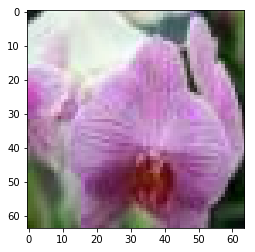

In [14]:
#get input image y
real_images=next(img_input)
batch_images = np.array(real_images).astype(np.float32)
img = (real_images[1,:,:,:] +1.)/2
plt.imshow(img)
plt.axis('on')
plt.show()

Define some masks, importance matrix and helper functions

In [38]:
def create_mask(scale):
    m = np.ones(image_shape)
    l = int(image_size*scale)
    u = int(image_size*(1.0-scale))
    m[l:u, l:u, :] = 0.0
    return m
   
def random_mask(fract):
    fraction_masked = fract
    m = np.ones(image_shape)
    m[np.random.random(image_shape[:2]) < fraction_masked] = 0.0
    
def merge_images(image_batch, size):
    h,w = image_batch.shape[1], image_batch.shape[2]
    c = image_batch.shape[3]
    img = np.zeros((int(h*size[0]), w*size[1], c))
    for idx, im in enumerate(image_batch):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w,:] = im
    return img

def reshape_masks(m):
    return np.resize(m, [batch_size] + image_shape)

#create the importance matrix
def create_imp_matrix():
    a=np.ones((64,64))
    n=64
    for k in range(1,16):
        for i in range(k,n-k):
            for j in range(k,n-k):
                a[i,j]+=1

    scale=0.25
    image_size=64
    sz = image_size
    l = int(image_size*scale)
    u = int(image_size*(1.0-scale))
    a[l:u, l:u] = 0.0

    non_zero_mean = np.sum(a)/(32*32)
    return a/32#non_zero_mean

Next we define the loss. As mentioned above this has two components.

### Contexual Loss

The contextual loss incorporates the information from the uncorrupted portion of the given image. It is used to measure the context similarity between the reconstructed image and the uncorrupted portion, which is defined as 

\begin{align*}
L_{contexual}(z) = ||M \odot G(z) - M \odot x||_1
\end{align*}

where $M$ denotes the binary mask of the uncorruption and $\odot$ denotes the element-wise product operation. The corrupted portion is not used in the loss. The choice of $L1$ norm is empirical. 


### Perceptual Loss

The perceptual loss encourages the reconstructed image to be similar to the samples in the data distribution used to train the GAN and we use the same loss for fooling $D$ as in GAN:

\begin{align*}
L_{perceptual}(z) = log(1 - D(G(z))
\end{align*}

Without $L_{perceptual}$, the mapping from $x$ to $z$ can converge to a perceptually implausible result and some reconstructed images tend to be unrealistic. 




The total loss is then defined as 
\begin{align*}
Loss(z) = L_{contexual}(z) + \lambda L_{perceptual}(z)
\end{align*}

where $\lambda$ is a hyperparameter we tune. In practice, $\lambda$ has to be relatively small to constrain the recovered image with the input pixels. We found value = 0.001 to work best.

We find the optimal image by doing projected gradient descent to minimize this loss.

In [39]:
#define hyperparameter to weigh the two losses
learning_r = 0.01
lambda_val = 0.001

#image completion
mask = tf.placeholder(tf.float32, [None] + image_shape, name='mask')
imp_matrix = tf.placeholder(tf.float32, [None] + image_shape, name='imp_matrix')

#define perceptual and contextual losses
perceptual_loss = gen_loss
contextual_loss = tf.reduce_sum(
    tf.contrib.layers.flatten(
        tf.multiply(tf.abs(tf.multiply(tf.cast(mask,tf.float32), tf.cast(G,tf.float32)) 
                           - tf.multiply(tf.cast(mask,tf.float32), tf.cast(images, tf.float32)))
                                        ,tf.cast(imp_matrix, tf.float32))), 1)

loss_ = contextual_loss + lambda_val*perceptual_loss
gradient_loss_ = tf.gradients(loss_, z)

#get mask M
mask_ = create_mask(0.25)
importance_matrix = create_imp_matrix()
batch_mask = reshape_masks(mask_)
imp_mask = reshape_masks(importance_matrix)
z_hat_batch = np.random.uniform(-1, 1, size=(batch_size, 100))

#projected gradient descent
for i in xrange(5000): 
    run = [loss_, gradient_loss_, G]
    loss, grad, G_imgs = sess.run(run, feed_dict={
        z: z_hat_batch,
        imp_matrix: imp_mask,
        mask: batch_mask,
        images: batch_images,})
    
    if (i%500 is 0):
        print ("loss in iteration: " + str(i) + " is: " + str(np.mean(loss)))
        
    z_hat_batch = np.clip(z_hat_batch - learning_r*grad[0], -1, 1)

loss in iteration: 0 is: 825.727
loss in iteration: 500 is: 250.502
loss in iteration: 1000 is: 255.339
loss in iteration: 1500 is: 264.981
loss in iteration: 2000 is: 265.09
loss in iteration: 2500 is: 258.692
loss in iteration: 3000 is: 253.039
loss in iteration: 3500 is: 254.474
loss in iteration: 4000 is: 254.169
loss in iteration: 4500 is: 250.957


In [40]:
np.mean(loss)

255.81247

After convergence, the corrupted image is mapped to the closest $z$ in the latent representation space: 

\begin{align*}
\hat{z} = argmin_{z}L_{contexual}(z) + \lambda L_{perceptual}(z)
\end{align*}.

Lets take a look a the generated images $G(\hat{z})$.

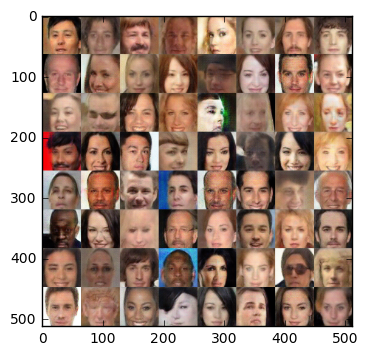

In [41]:
created_images = (G_imgs + 1.)/2
im = merge_images(created_images, [8,8])
plt.imshow(im)
plt.axis('on')
plt.show()

Lets take a look a the input images after applying the mask.

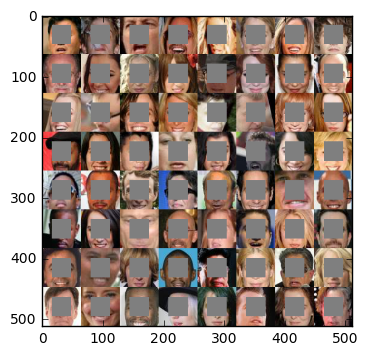

In [42]:
masked_images = np.multiply(batch_images, batch_mask)
input_images = (masked_images + 1.)/2
im = merge_images(input_images, [8,8])
plt.imshow(im)
plt.axis('on')
plt.show()

In [43]:
inv_mask_ = 1- mask_
inv_batch_mask = np.resize(inv_mask_, [batch_size] + image_shape)
inv_masked_images = np.multiply(batch_images, inv_batch_mask)

inv_input_images = (inv_masked_images + 1.)/2
im_ = merge_images(inv_input_images, [8,8])
plt.imshow(im_)
plt.axis('on')
plt.show()

### Image Reconstruction

Fianlly we use the optimal $\hat{z}$, to do image inpainting: 

\begin{align*}
x_{reconstructed} = M \odot x + (1 - M) \odot G{(\hat{z})}
\end{align*}

<img src='assets/image_reconstruction.jpg'>

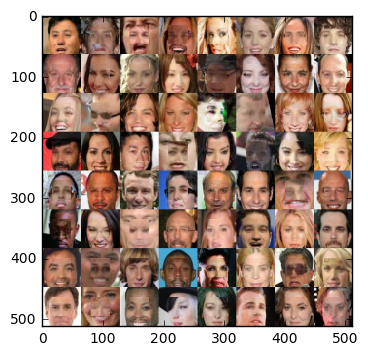

In [45]:
inv_batch_mask = np.resize(inv_mask_, [batch_size] + image_shape)
inv_masked_images = np.multiply(G_imgs, inv_batch_mask)
Recons_img = inv_masked_images + masked_images
rec_images = (Recons_img + 1.)/2
im_r = merge_images(rec_images, [8,8])
plt.imshow(im_r)
plt.axis('on')
plt.show()

Some of these look quite good. The important matrix adds a nice gradient smoothing around the hole in the center. The consistent nature of most of the images i.e. two eyes, a nose a mouth in roughly the same part of each image helps a lot. It does a poor job on images that are very close up. It gets the skin tone right most of the time. It even tries to complete sunglasses and eyebrows.   

<b> Completing our faces</b>
We were curious to see how the network would complete our faces sodecided to test it out. 
<img src='assets/face_completion_us.jpg'>

It makes us look weird, however if we look at it objectively, it actually does a pretty good job. It captures our skin tones nearly perfectly. It completes Aashima's(top left) eyes, makes a bigger nose than it should, but she only slightly looks like an alien. Nishant's(top right) face it completes well, right down to the black eye it knows should be there. It captures the structure of his face, the relative size of his features, and overall does a good job. In Siddharth's(bottom) image, it actually does a very good job completing the eyebrows. The glasses (or lack of them) look weird, but apart from that, the image looks seamlessly integrated.

## Completion on flowers
<img src='assets/flower_completion.jpg'>

Compared to faces the image completion results on flowers are poorer. This is due to the wide variety in the structure of flowers. There is no consistency as each flowers have different kinds of petals. Additionally unlike faces some training images had multiple flowers in the frame and were taken from different distances to the flower.

# Final Observations

We started out our project with flowers, and on Prof. Belhumeur's suggestion, incorporated faces as well. Due to these two distinct datasets, and the behaviors of their distinct outputs, we were able to make some interesting observations that we summarize here- 

1. It is much easier for humans to judge generated images of faces, than to judge generated images of flowers. This is due to the fact that faces have a structure that is ingrained in our minds. We immediately notice anything out of the usual. However, most humans do not come across sooo many different variations in flowers (102 categories in the original dataset alone - plus our GAN generates its own unique flowers).
2. Flowers are a more challenging dataset than faces, both for Image Generation, and for Image Completion. In image generation, our network must learn the infinite complexities that define the distribution of flowers. Faces, we feel, have a more base structure. The eyes, nose, mouth, jaw, hair. There are variations in these as well, however, the underlying structure remains the same. Similarly in image completion, we see big variations in the output for flowers, while the network does a better job with faces. Another reasons for this could be the fact that our dataset of faces had over 200,000 images, whilst our flower dataset, even with augmentation was around 80,000 images.


# Future Work
1. We can look into techniques to boost generated image quality - they look sharp for $64\times64$ images. We can increase the size to $128\times128$.
2. We can incorporate 'walking into the latent space', a technique superior to nearest neighbours and check for overfitting.
3. Add Dropout layers in both generator and discriminator ($50\%$)
4. Follow the unrolled GAN approach(Invert the loss function to $G$)
5. Add Virtual Batch Normalization
6. Add new classes and examine quality using Inception Scoring.